In [37]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from tqdm.auto import tqdm
import contextlib

In [29]:
@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar class instance"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

#  1. Data Loading and Cleaning

In [30]:
try:
    df = pd.read_csv("spotify_songs.csv", encoding='latin-1')
except Exception as e:
    print(f"Error loading CSV: {e}")
    exit()

columns_to_drop = [
    'id', 'track_name', 'track_album_name', 'track_album_release_date',
    'Key Word', 'Mode_name', 'Tempo_Category', 'Track_Length_Bucket',
    'playlist_name'
]
df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')
df_cleaned = df_cleaned.dropna(subset=['Track Popularity Score'])

# 2. Feature Engineering (Using Best Features)

In [31]:
# A. Interaction Feature
df_cleaned['Energy_Acoustic_Interaction'] = df_cleaned['energy'] * (1 - df_cleaned['acousticness'])
# B. Ratio Feature
epsilon = 1e-6
df_cleaned['Loudness_Per_Duration'] = df_cleaned['loudness'] / (df_cleaned['Duration_Min'] + epsilon)

# 3. Encoding and Imputation

In [32]:
artist_avg_popularity = df_cleaned.groupby('track_artist')['Track Popularity Score'].transform('mean')
df_cleaned['track_artist_encoded'] = artist_avg_popularity
df_cleaned = df_cleaned.drop(columns=['track_artist'])

df_final = pd.get_dummies(df_cleaned, columns=['playlist_genre', 'playlist_subgenre', 'Decade'], drop_first=True)

impute_cols = [
    'Release Year', 'Danceability', 'energy', 'loudness', 'mode',
    'speechiness', 'acousticness', 'instrumentalness', 'liveness',
    'valence', 'Duration_Min', 'key', 'track_artist_encoded',
    'Energy_Acoustic_Interaction', 'Loudness_Per_Duration'
]
for col in impute_cols:
    if col in df_final.columns:
        df_final[col] = df_final[col].fillna(df_final[col].mean())

# 4. Select Ultimate Feature Set

In [33]:
TOP_FEATURES_TO_KEEP = [
    'track_artist_encoded', 'Release Year', 'tempo', 'liveness', 'valence',
    'speechiness', 'Danceability', 'loudness', 'Loudness_Per_Duration',
    'acousticness', 'Duration_Min', 'energy', 'Energy_Acoustic_Interaction'
]

X = df_final[TOP_FEATURES_TO_KEEP].copy()
y = df_final['Track Popularity Score']

scaler = MinMaxScaler()
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Train Final Portfolio Model
# Using 300 estimators

In [34]:
n_estimators = 300
print(f"Training Final Random Forest Model with {n_estimators} trees...")
print("This will take significantly less time than the massive search.")

rf_model = RandomForestRegressor(
    n_estimators=n_estimators,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Run Fit with TQDM Progress Bar
start_time = time.time()
with tqdm_joblib(tqdm(desc="Training Progress", total=n_estimators)) as progress_bar:
    rf_model.fit(X_train, y_train)
end_time = time.time()

print(f"\nTraining took {end_time - start_time:.2f} seconds.")

Training Final Random Forest Model with 300 trees...
This will take significantly less time than the massive search.


Training Progress:   0%|          | 0/300 [00:00<?, ?it/s]


Training took 94.02 seconds.


# 6. Final Evaluation

In [36]:
y_train_pred = rf_model.predict(X_train)
y_test_pred = rf_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print("\n--- FINAL MODEL RESULTS ---")
print("Target Variable: Track Popularity Score (0-100)")
print("-" * 50)
print(f"Training R-squared (R²): {train_r2:.4f}")
print(f"Testing R-squared (R²): {test_r2:.4f}")
print(f"Testing Mean Absolute Error (MAE): {test_mae:.2f} points")
print("-" * 50)


--- FINAL MODEL RESULTS ---
Target Variable: Track Popularity Score (0-100)
--------------------------------------------------
Training R-squared (R²): 0.9314
Testing R-squared (R²): 0.6008
Testing Mean Absolute Error (MAE): 10.08 points
--------------------------------------------------


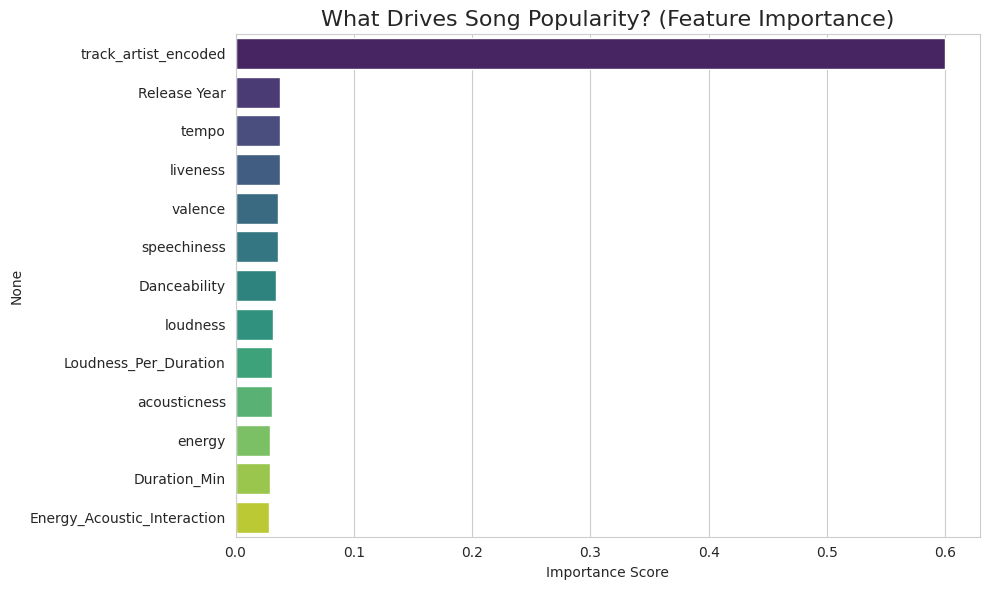

In [39]:
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# --- PLOT 1: Feature Importance (The "Why") ---
plt.figure(figsize=(10, 6))
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
sns.barplot(x=importances.values, y=importances.index, palette="viridis", hue=importances.index, legend=False)
plt.title("What Drives Song Popularity? (Feature Importance)", fontsize=16)
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

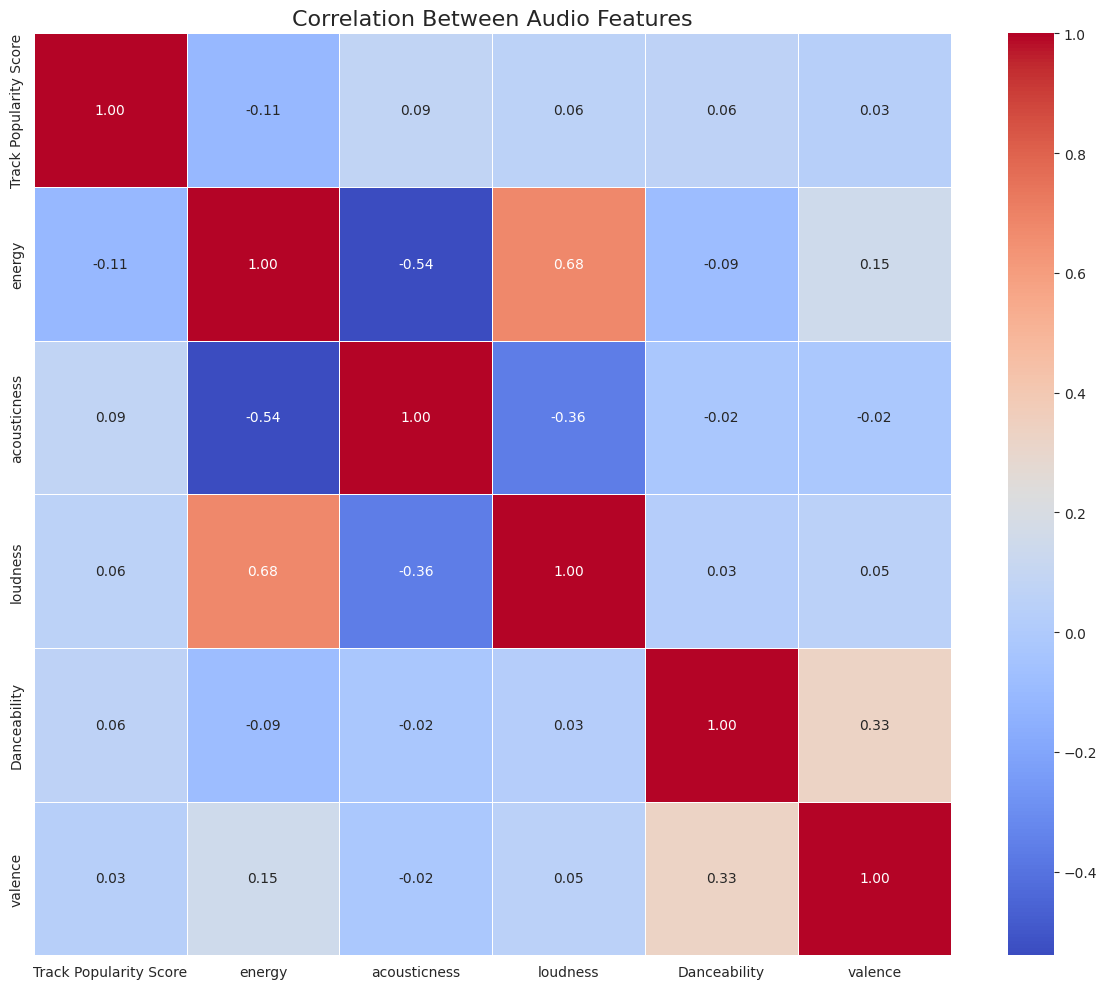

In [40]:
# --- PLOT 2: Correlation Heatmap (The "Interactions") ---
plt.figure(figsize=(12, 10))

heatmap_cols = ['Track Popularity Score', 'energy', 'acousticness', 'loudness', 'Danceability', 'valence']
corr_matrix = df_cleaned[heatmap_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Between Audio Features", fontsize=16)
plt.tight_layout()
plt.show()

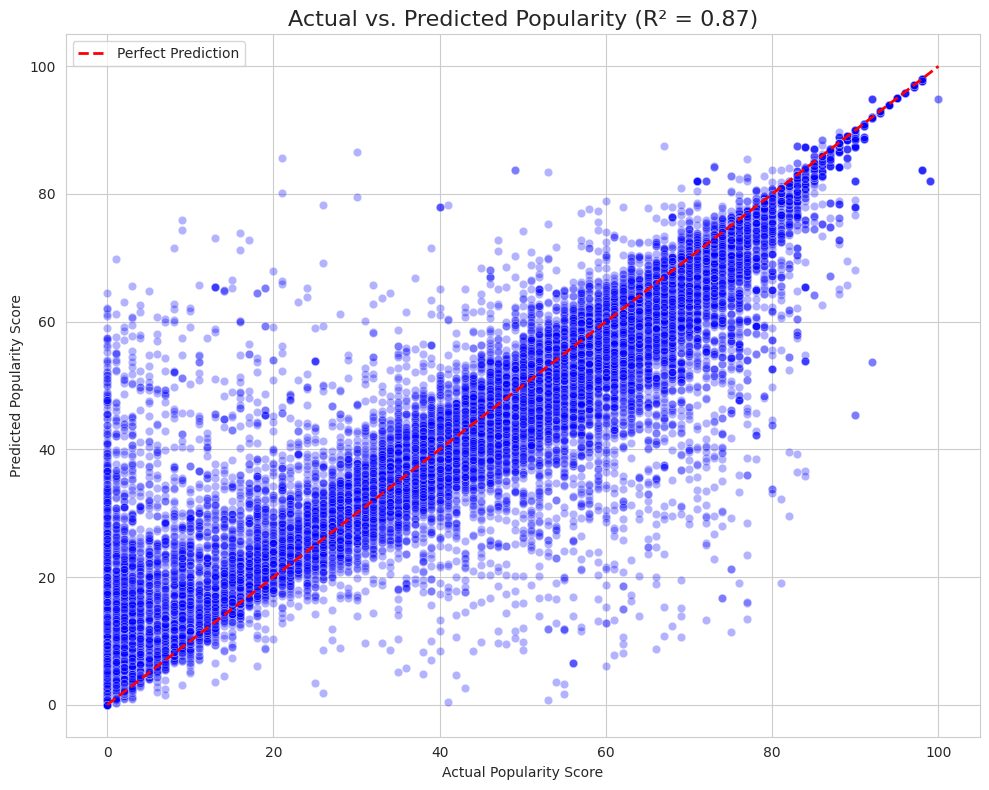

In [42]:
# --- PLOT 3: Actual vs. Predicted (The "Performance") ---

y_pred = rf_model.predict(X)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=y, y=y_pred, alpha=0.3, color='blue')

plt.plot([0, 100], [0, 100], '--', color='red', linewidth=2, label="Perfect Prediction")
plt.title(f"Actual vs. Predicted Popularity (R² = {rf_model.score(X,y):.2f})", fontsize=16)
plt.xlabel("Actual Popularity Score")
plt.ylabel("Predicted Popularity Score")
plt.legend()
plt.tight_layout()
plt.show()

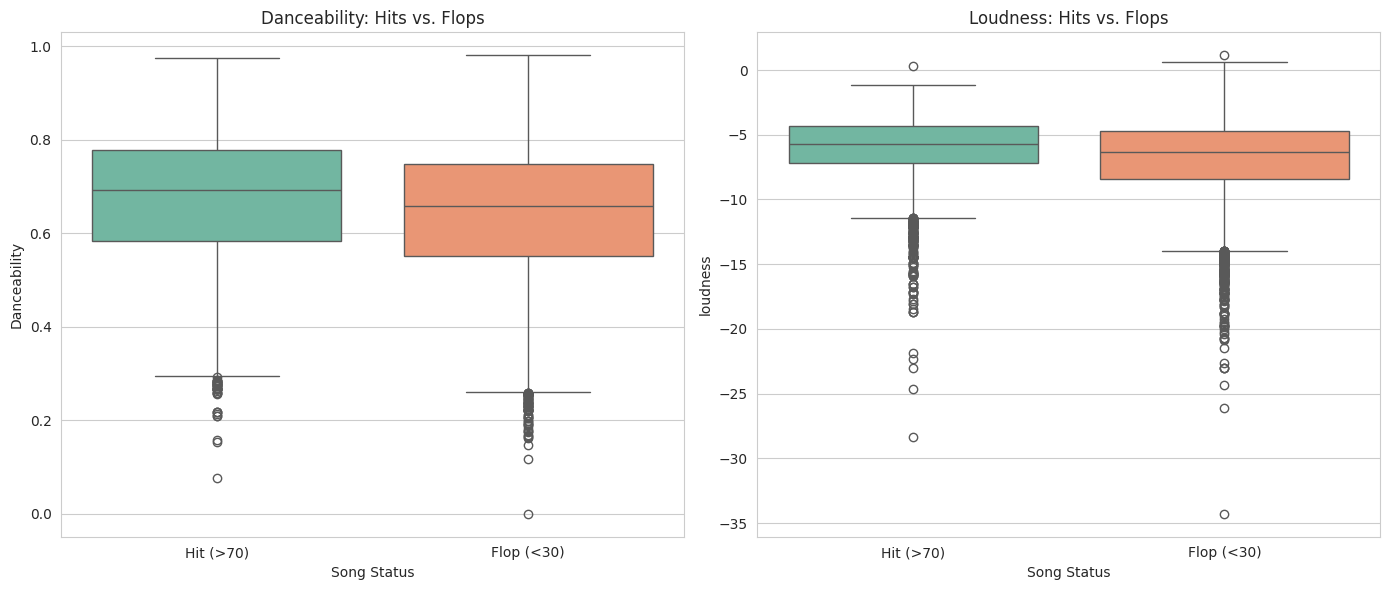

In [43]:
# --- PLOT 4: Box Plots for "Hit" vs "Flop" (The "Distribution") ---
plot_df = df_cleaned.copy()
plot_df['Song Status'] = plot_df['Track Popularity Score'].apply(lambda x: 'Hit (>70)' if x > 70 else ('Flop (<30)' if x < 30 else 'Average'))
plot_df = plot_df[plot_df['Song Status'] != 'Average'] # Comparison between extremes

plt.figure(figsize=(14, 6))

# Subplot 1: Danceability
plt.subplot(1, 2, 1)
sns.boxplot(x='Song Status', y='Danceability', data=plot_df, palette="Set2", hue='Song Status')
plt.title("Danceability: Hits vs. Flops")

# Subplot 2: Loudness
plt.subplot(1, 2, 2)
sns.boxplot(x='Song Status', y='loudness', data=plot_df, palette="Set2", hue='Song Status')
plt.title("Loudness: Hits vs. Flops")

plt.tight_layout()
plt.show()